In [1]:
cd ..

/Users/adamnavarroliriano/miniconda3/envs/language-api/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/Users/adamnavarroliriano/Documents/Personal/Code/language/language-api


In [62]:
import pandas as pd
import numpy as np 
import ast
from plotnine import *
from itertools import permutations
from sacrebleu.metrics import BLEU
from sacrebleu import sentence_bleu
from src.models.pretrained import load_models
import time
import os
import scipy.stats as st

## Read metadata

In [3]:
with open('data/train.metadata') as f:
    metadata = f.readlines()
    
metadata = [ast.literal_eval(line.strip()) for line in metadata]
metadata_df = pd.DataFrame(metadata)

### Metadata sizes

In [4]:
language_pairs_qty = metadata_df.groupby(['src_lang', 'tgt_lang']).size().reset_index().rename(columns={0:'obs'})
language_pairs_qty['language_pair'] = language_pairs_qty['src_lang'] + ' - ' + language_pairs_qty['tgt_lang']
language_pairs_qty.sort_values(by='obs')

,src_lang,tgt_lang,obs,language_pair
10,sv,en,89513,sv - en
4,en,nb,89786,en - nb
9,sv,da,93665,sv - da
7,nb,en,99447,nb - en
0,da,en,103097,da - en
3,en,da,108729,en - da
5,en,sv,139502,en - sv
8,nb,sv,141412,nb - sv
1,da,nb,150826,da - nb
11,sv,nb,152931,sv - nb


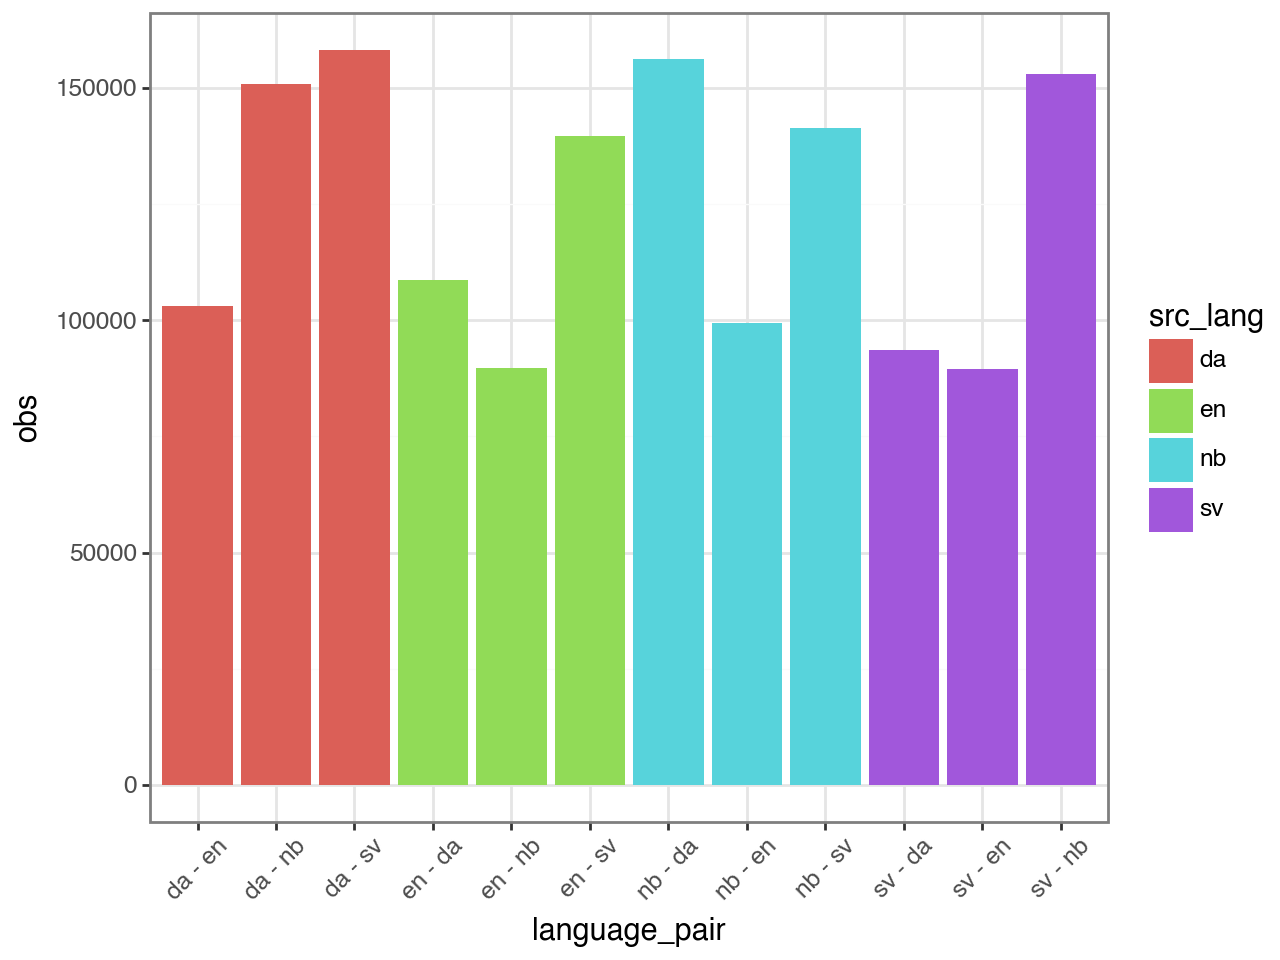

In [5]:
(
    ggplot(language_pairs_qty, aes(x='language_pair', y='obs', fill='src_lang')) +
    geom_bar(stat='identity') +
    theme_bw() + 
    theme(axis_text_x= element_text(angle=45))
    
)

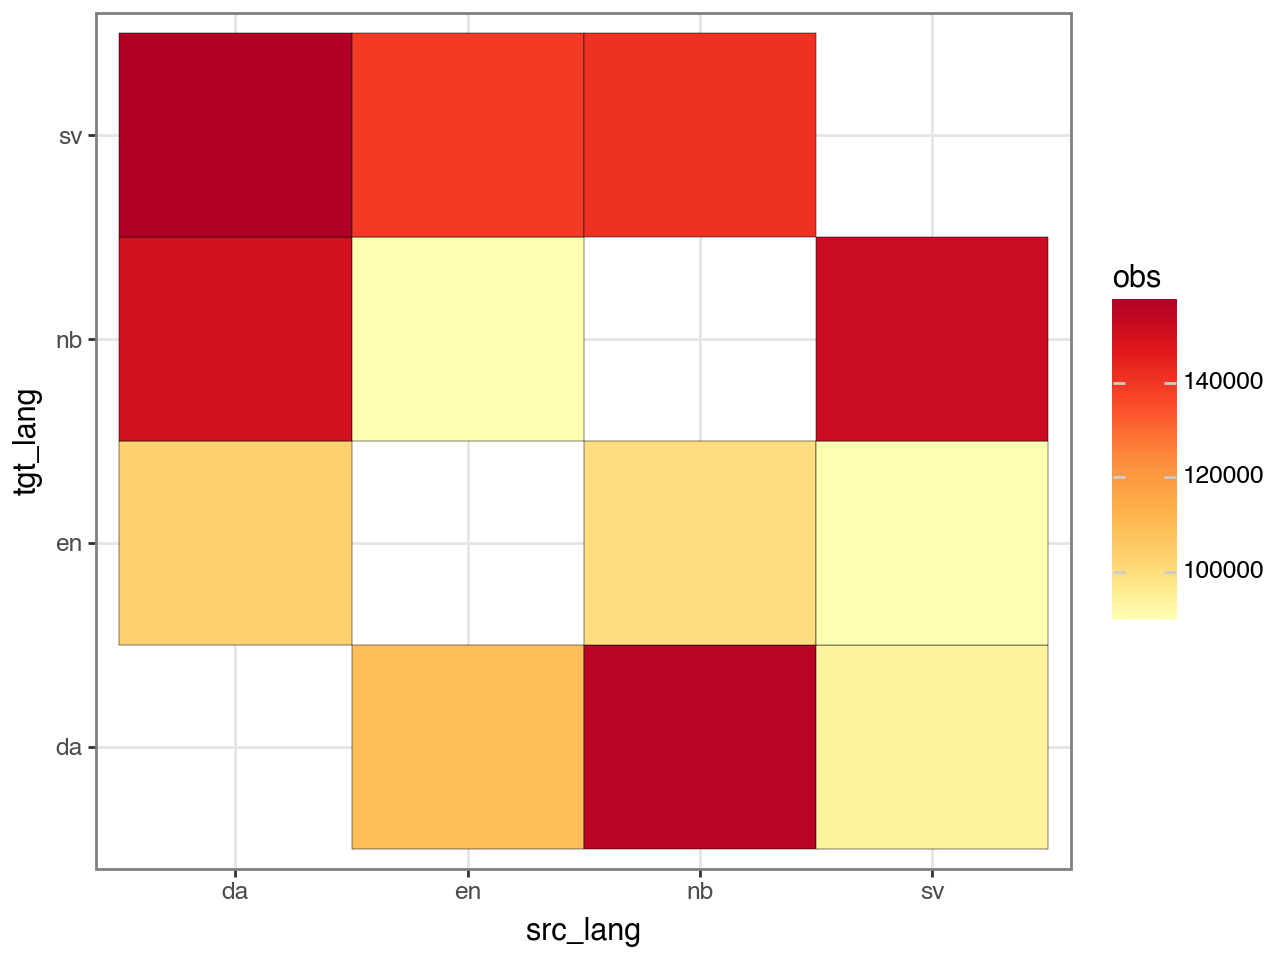

In [6]:
(
    ggplot(language_pairs_qty, aes(x='src_lang', y='tgt_lang', fill='obs')) +
    geom_tile(color='black') +
    scale_fill_distiller(palette='YlOrRd', 
                         limits=[language_pairs_qty['obs'].min(), language_pairs_qty['obs'].max()],
                         direction=1) +
    theme_bw()
    
)

## Data distribution

In [7]:
languages = ('en', 'da', 'sv', 'nb')
language_pairs = list(permutations(languages, 2))

sample_indices = pd.DataFrame()
sample_size = 5000
for src, tgt in language_pairs:
    pair_indices = metadata_df.loc[(metadata_df['src_lang'] == src) & (metadata_df['tgt_lang'] == tgt)].sample(n=5000, random_state=0)
    sample_indices = pd.concat([sample_indices, pair_indices])
    


## Distributions (lens, characters, etc)

In [8]:
with open('data/train.src', 'r') as f:
    train_src = f.readlines()

with open('data/train.tgt', 'r') as f:
    train_tgt = f.readlines()

In [9]:
translation_df = metadata_df.copy()
translation_df['src_text'] = train_src
translation_df['tgt_text'] = train_tgt

# Strip trailing spaces
translation_df['src_text'] = translation_df['src_text'].str.strip()
translation_df['tgt_text'] = translation_df['tgt_text'].str.strip()

# Compute character lens
translation_df['src_len'] = translation_df['src_text'].str.len()
translation_df['tgt_len'] = translation_df['tgt_text'].str.len()

In [10]:
translation_df[['src_len', 'tgt_len']].corr()

,src_len,tgt_len
src_len,1.000000,0.979144
tgt_len,0.979144,1.000000


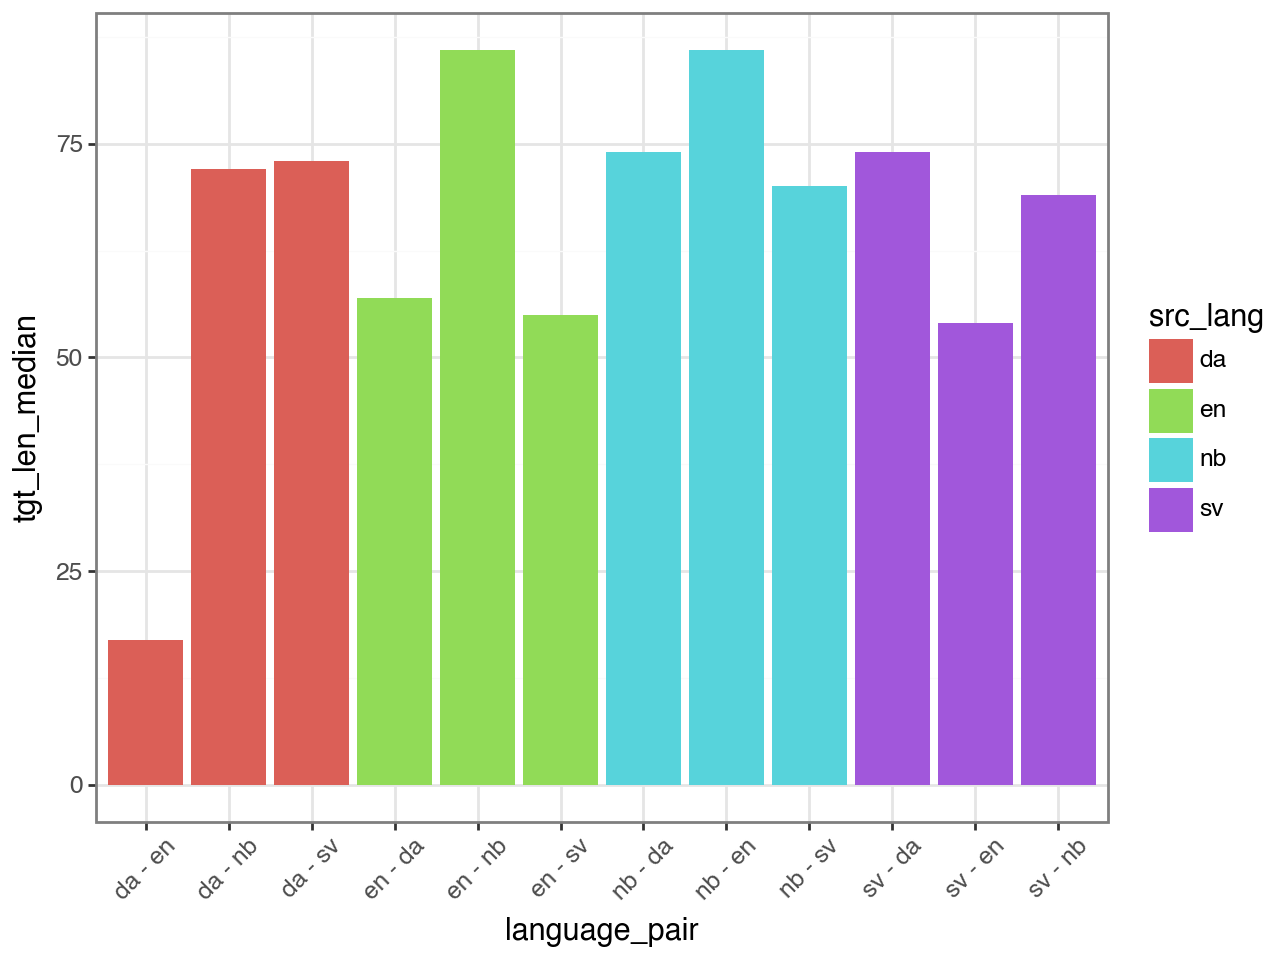

In [11]:
# Aggregate
len_distribution_df = (translation_df
 .groupby(['src_lang', 'tgt_lang'])[['src_len', 'tgt_len']]
 .agg(['mean', 'median', 'min', 'max', ('p90', lambda x: np.quantile(x, 0.95))])
 .reset_index()
)
len_distribution_df.columns=[col[0] if col[1]=='' else '_'.join(col) for col in len_distribution_df.columns]
len_distribution_df['language_pair'] = len_distribution_df['src_lang'] + ' - ' + len_distribution_df['tgt_lang']

(
    ggplot(len_distribution_df, aes(x='language_pair', y='tgt_len_median', fill='src_lang')) +
    geom_bar(stat='identity') +
    theme_bw() + 
    theme(axis_text_x= element_text(angle=45))
    
)

In [12]:
translation_df['src_tokens'] = translation_df['src_text'].str.split().apply(len)
translation_df['tgt_tokens'] = translation_df['tgt_text'].str.split().apply(len)

In [15]:
translation_df.groupby(['src_lang', 'tgt_lang'])[['src_tokens', 'tgt_tokens']].agg(['median', ('p90', lambda x: np.quantile(x, 0.9))])

src_tokens       tgt_tokens      
                      median   p90     median   p90
src_lang tgt_lang                                  
da       en              2.0  36.0        3.0  37.0
         nb             12.0  26.0       12.0  26.0
         sv             12.0  28.0       12.0  27.0
en       da              9.0  43.0        9.0  41.0
         nb             14.0  29.0       14.0  28.0
         sv             10.0  26.0       10.0  24.0
nb       da             12.0  26.0       12.0  26.0
         en             14.0  28.0       14.0  29.0
         sv             12.0  26.0       11.0  25.0
sv       da             12.0  27.0       12.0  28.0
         en              9.0  24.0       10.0  26.0
         nb             11.0  25.0       12.0  26.0

## BLEU scores for samples

To compute BLEU score for each pair, we use a Kaggle GPU. Below are the results of the translations tables

In [16]:
translation_df.to_parquet('data/translation_merged.parquet', index=False)

After running the translations through models, we find that there are 4 language pairs which are not supported by the family of MarianMT models

In [36]:
files_translations = os.listdir('data/kaggle/')
files_translations = [file for file in files_translations if file.endswith('.csv')]
bleu_scores = pd.concat([pd.read_csv(f"data/kaggle/{file}") for file in files_translations])

We are also are going to assume that the case is not important to compute BLEU

In [123]:
def bootstrap(array:pd.Series, func:callable,  times=1000, seed=0):
    resample_results =[]

    for i in range(times):
        agg_value = func(array.sample(frac=1, replace=True, random_state=seed + i))
        resample_results.append(agg_value)
    
    return resample_results
    

In [171]:
# Compute BLEU in lower case, assuming it is not important for the use case
bleu_scores['bleu'] - bleu_scores.apply(lambda x: sentence_bleu(x['translation'], [x['tgt_text']]).score, axis=1)
bleu_scores['bleu_lowercase'] = bleu_scores.apply(lambda x: sentence_bleu(x['translation'].lower(), [x['tgt_text'].lower()]).score, axis=1)

# Sort by lang_pair and src_text to ensure reproducibility in bootstrap interval
bleu_scores = bleu_scores.sort_values(by=['lang_pair', 'src_text']).reset_index(drop=True)

Now we compute the mean and a confidence interval for the BLEU mean at 90% confidence level.

In [176]:
agg_bleu_scores = bleu_scores.groupby('lang_pair')[['bleu', 'bleu_lowercase']].mean()

# Compute bootstrap array for the mean value of BLEU scores
bs_bleu_scores = bleu_scores.groupby('lang_pair')[['bleu', 'bleu_lowercase']].agg(lambda x: bootstrap(x, func=np.mean, times=1000, seed=0))
agg_bleu_scores.loc[:, ['bleu_array', 'bleu_lowercase_array']] = bs_bleu_scores.values

# Compute lower and upper bounds for the confidence interval at 90 level
p = 0.9
quantiles = [(1-p)/2, (1+p)/2]
agg_bleu_scores

agg_bleu_scores.loc[:, ['bleu_lower', 'bleu_upper']] = agg_bleu_scores['bleu_array'].apply(lambda x: np.quantile(x, quantiles)).apply(pd.Series).values
agg_bleu_scores.loc[:, ['bleu_lowercase_lower', 'bleu_lowercase_upper']] = agg_bleu_scores['bleu_lowercase_array'].apply(lambda x: np.quantile(x, quantiles)).apply(pd.Series).values


In [178]:
agg_bleu_scores = agg_bleu_scores.reset_index()

In [209]:
agg_bleu_scores['lang_pair'] = agg_bleu_scores['lang_pair'].astype('category')
agg_bleu_scores['xmin'] = agg_bleu_scores['lang_pair'].cat.codes - 0.4
agg_bleu_scores['xmax'] = agg_bleu_scores['lang_pair'].cat.codes + 0.4
agg_bleu_scores[['src', 'tgt']] = agg_bleu_scores['lang_pair'].str.split('_', expand=True)
agg_bleu_scores['lang_mix'] = agg_bleu_scores[['src', 'tgt']].apply(lambda x: '+'.join(sorted(x)), axis=1)

In [211]:
agg_bleu_scores

,lang_pair,bleu,bleu_lowercase,bleu_array,bleu_lowercase_array,bleu_lower,bleu_upper,bleu_lowercase_lower,bleu_lowercase_upper,xmin,xmax,src,tgt,lang_mix
0,da_en,40.084695,46.944442,"[40.02007437403939, 40.71539683951452, 40.0716...","[47.05472876387384, 47.46284030665249, 46.5269...",39.259591,40.834336,46.179168,47.746758,-0.4,0.4,da,en,da+en
1,da_nb,33.418992,34.265913,"[33.18433779459912, 33.3493125843948, 33.44354...","[33.998614890258025, 34.11162582557566, 34.298...",32.880660,33.916733,33.724193,34.779253,0.6,1.4,da,nb,da+nb
2,en_da,40.330410,42.552434,"[39.95437505795683, 40.93645720614752, 40.8071...","[42.34350757617539, 43.349872009371595, 43.031...",39.625116,41.031988,41.836210,43.244737,1.6,2.4,en,da,da+en
3,en_sv,32.802975,33.939166,"[32.32370131781808, 32.485605271854496, 32.235...","[33.65662403458756, 33.67047721937101, 33.3595...",32.253030,33.326605,33.404048,34.496669,2.6,3.4,en,sv,en+sv
4,nb_da,35.423737,36.499796,"[35.538929709179556, 35.260222413018404, 35.95...","[36.61966069156378, 36.23257978390298, 37.0777...",34.857513,35.954234,35.941022,37.032546,3.6,4.4,nb,da,da+nb
5,nb_sv,33.042935,33.972191,"[32.95251212928403, 32.42030004756446, 32.9963...","[33.84202189838272, 33.29191379222392, 33.8892...",32.477887,33.570326,33.389820,34.507646,4.6,5.4,nb,sv,nb+sv
6,sv_en,35.083205,37.748324,"[35.610127063873925, 35.16528536194659, 35.193...","[38.27569115811223, 37.852829347663295, 37.865...",34.541777,35.597871,37.192103,38.295782,5.6,6.4,sv,en,en+sv
7,sv_nb,32.537478,33.325157,"[32.71819270150836, 32.655555208772306, 32.397...","[33.510907206904896, 33.36474150247418, 33.126...",32.001473,33.030078,32.784035,33.840918,6.6,7.4,sv,nb,nb+sv


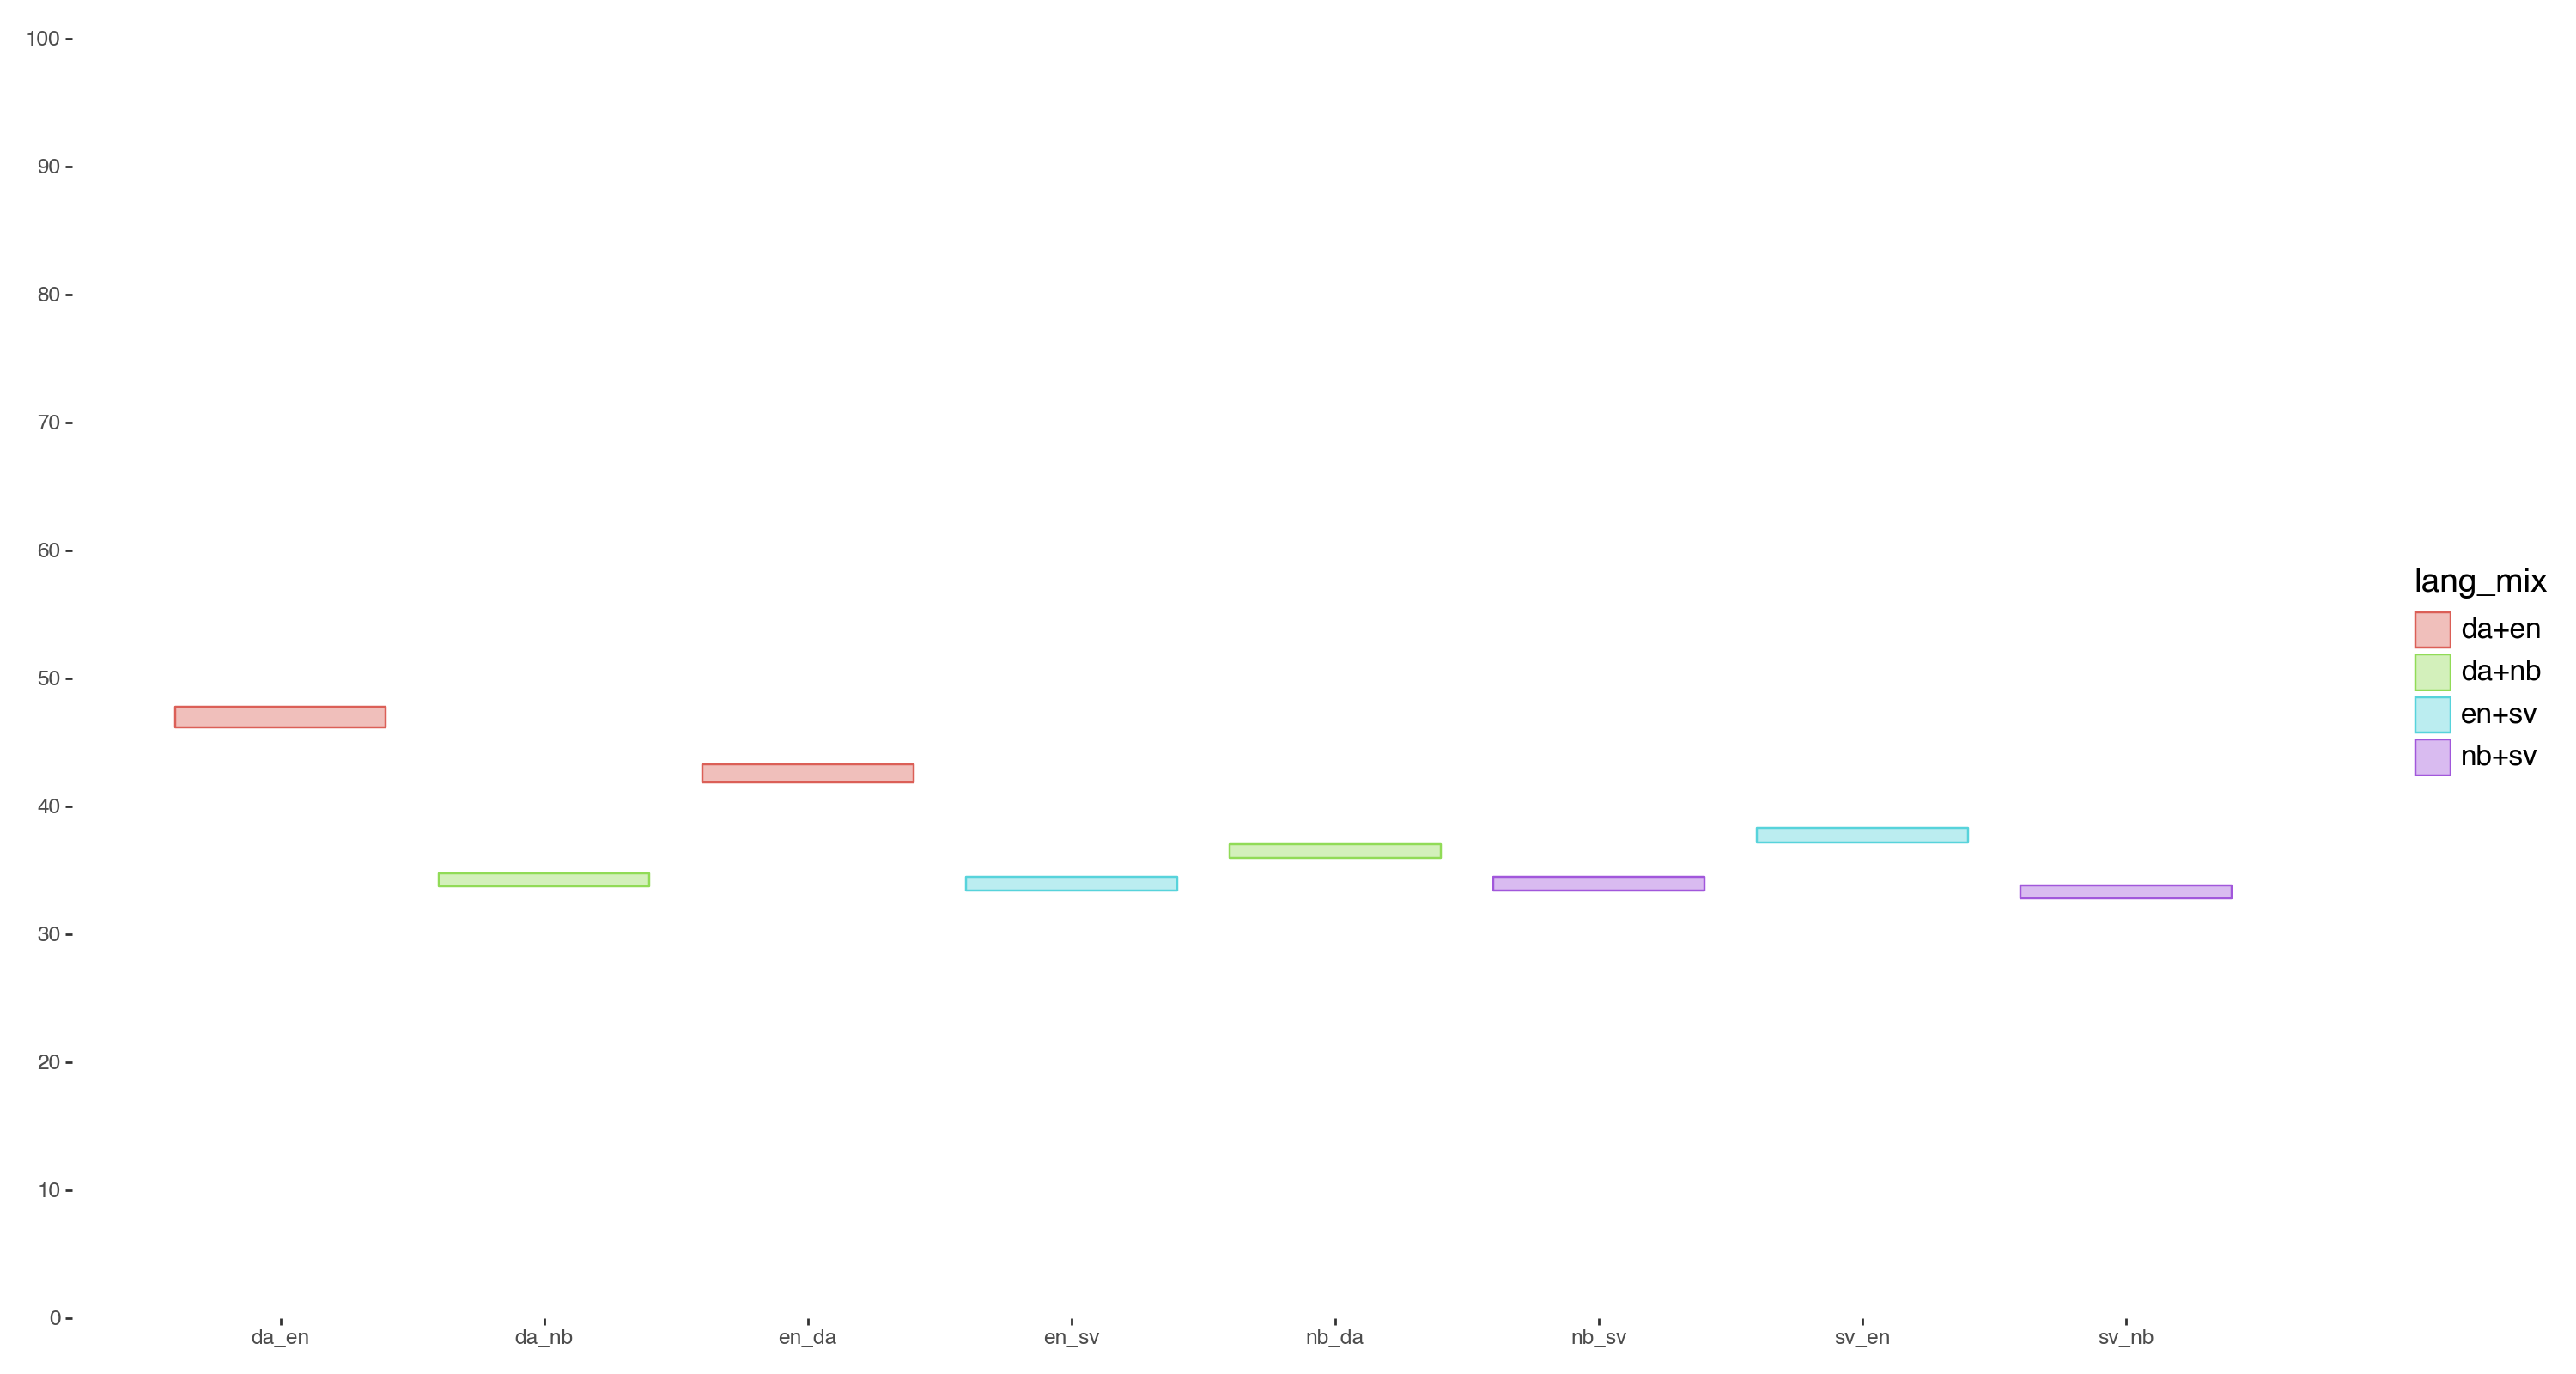

In [212]:
(
ggplot(agg_bleu_scores) +
geom_rect(aes(xmin='xmin', xmax='xmax',
              ymin='bleu_lower', ymax='bleu_lowercase_upper',
             fill='lang_mix',  color='lang_mix') ,
          alpha=0.4,
          position = 'dodge') +
#geom_rect(aes(xmin='xmin', xmax='xmax', ymin='match',
#              ymax='match', fill='provider_id', color='provider_id'),
#          alpha=0,
#          position='dodge') +
#facet_wrap('~country_name') + 
scale_y_continuous(limits=[0,101],expand = [0,0], breaks=np.arange(0, 101, 10), labels=lambda breaks: [str(x) for x in breaks]) +
# scale_fill_manual(values=colors) +
# scale_color_manual(values=colors) +
scale_x_continuous(breaks=agg_bleu_scores['lang_pair'].cat.codes.unique().tolist(),
                  labels=agg_bleu_scores['lang_pair'].unique().tolist()) +
coord_cartesian(ylim=[0,101]) +
theme(figure_size=(15, 8)) +
theme(panel_background = element_blank(),
    legend_background = element_blank(),
    legend_key = element_blank()
    , legend_direction =  'vertical'
    , legend_title = element_text(size = 14, face = 'bold')
    , legend_text = element_text(size=12),
    legend_box_background = element_rect(color="black", size=0.5)) 
    )